1. Buat model Deep learning MLP (PyTorch and Tensorflow). Column "Cover_Type" adalah target.
2. Gunakan Matriks Evaluasi (Akurasi,Presisi,Recall,F1Squared, AUC, ROC)
3. Beri penjelasan untuk setiap persamaan matematika yang ada.

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load dataset
df = pd.read_csv("compressed_data.csv.gz")

# Handle missing values
df.fillna(df.median(), inplace=True)

In [3]:
# Encode target variable
label_encoder = LabelEncoder()
df["Cover_Type"] = label_encoder.fit_transform(df["Cover_Type"])

In [4]:
# Define features and target
X = df.drop(columns=["Cover_Type"])
y = df["Cover_Type"]

In [5]:
# Convert categorical variables (if any)
X = pd.get_dummies(X, drop_first=True)

In [6]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#PyTorch

In [8]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)


In [9]:
# Create DataLoader for PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
# Define PyTorch Model
class MLPClassification(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLPClassification, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
# Initialize PyTorch Model
input_dim = X_train.shape[1]
output_dim = len(np.unique(y))
model = MLPClassification(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Train PyTorch Model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()


In [14]:
# Evaluate PyTorch Model
model.eval()
with torch.no_grad():  # Disable gradient calculation during inference
    y_pred_torch = model(X_test_tensor)
    # Apply softmax to get probabilities
    y_pred_probs = torch.softmax(y_pred_torch, dim=1).cpu().numpy()

y_pred_torch_labels = np.argmax(y_pred_probs, axis=1)  # Use probabilities for argmax
auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr') # Pass probabilities to roc_auc_score

#Tensorflow

In [15]:
# Build TensorFlow Model
model_tf = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(output_dim, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# Compile and Train TensorFlow Model
model_tf.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_tf.fit(X_train, y_train, epochs=20, batch_size=64, verbose=0)

In [17]:
# Evaluate TensorFlow Model
y_pred_tf = model_tf.predict(X_test)
y_pred_tf_labels = np.argmax(y_pred_tf, axis=1)
auc_tf = roc_auc_score(y_test, y_pred_tf, multi_class='ovr')

3632/3632 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


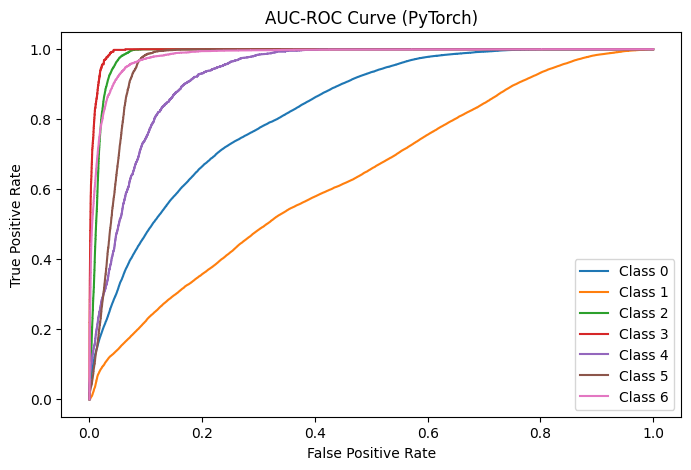

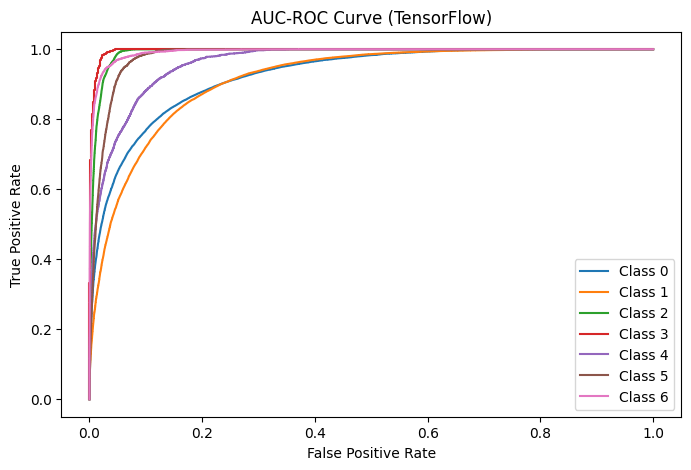

In [18]:
# Plot AUC-ROC Curves
plt.figure(figsize=(8, 5))
for i in range(output_dim):
    fpr, tpr, _ = roc_curve(y_test, y_pred_torch[:, i], pos_label=i)
    plt.plot(fpr, tpr, label=f'Class {i}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve (PyTorch)')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(output_dim):
    fpr, tpr, _ = roc_curve(y_test, y_pred_tf[:, i], pos_label=i)
    plt.plot(fpr, tpr, label=f'Class {i}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve (TensorFlow)')
plt.legend()
plt.show()

#Performa model

berdasarkan output sebelumnya, AUC-ROC Score atau nilai AUC-ROC yang dihitung menggunakan roc_auc_score(y_test, y_pred_torch, multi_class='ovr') menunjukkan seberapa baik model dalam membedakan kelas. Semakin mendekati 1, maka semakin baik modelnya.
pada grafik AUC-ROC menunjukkan trade-off antara True Positive Rate (TPR) dan False Positive Rate (FPR) untuk setiap kelas. Jika kurva mendekati sudut kiri atas, maka model memiliki performa klasifikasi yang lebih baik.
pada model TensorFlow
AUC-ROC Score atau performa model TensorFlow dihitung dengan cara yang sama, dan hasilnya dibandingkan dengan model PyTorch. Bentuk kurva untuk model TensorFlow dibandingkan dengan PyTorch untuk melihat model mana yang lebih unggul.

#Evaluasi output
Jika AUC-ROC model PyTorch lebih tinggi dari TensorFlow, berarti model PyTorch lebih baik dalam membedakan kelas.
Jika Precision tinggi tetapi Recall rendah, model cenderung lebih konservatif dalam memprediksi positif.
Jika Recall tinggi tetapi Precision rendah, model terlalu banyak memprediksi positif, sehingga ada banyak False Positives.
Jika kurva ROC hampir lurus diagonal, berarti model tidak lebih baik dari tebakan acak. sehingga model yang terbaik untuk dataset tersebut adalah AUC-ROC score.